In [135]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


#
from torch_geometric.utils import to_networkx
import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn_model import RGCN



In [5]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [6]:

def convert_binary(sparse_tensor, threshold):
    # convert values to either 0 or 1 based on a threshold of 0.5
    mask = sparse_tensor._values() > threshold
    converted_values = torch.zeros_like(sparse_tensor._values())
    converted_values[mask] = 1
    #print number of non zero values
    print("Number of non zero values: ", converted_values.nonzero().size(0))

    # create a new sparse tensor with the converted values
    converted_sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), converted_values, size=sparse_tensor.size())
    return converted_sparse_tensor

In [138]:
name = 'am'
data = kg.load(name, torch=True)
data = prunee(data, 2)
data.withheld
# model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

loaded data am (28.88s).


tensor([[ 772026,       4],
        [ 239273,       1],
        [ 726856,       4],
        ...,
        [ 756836,       7],
        [1358781,       5],
        [ 333111,       2]], dtype=torch.int32)

In [103]:
name = 'am'

data = kg.load(name, torch=True) 
print(data.triples.shape[0])
node_idx = 5678

# else:
#     data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')

data = prunee(data, 2)
print(data.triples.shape[0])
data.triples = torch.Tensor(data.triples).to(int)#data.triples.clone().detach()
data.withheld = torch.Tensor(data.withheld).to(int)#data.withheld.clone().detach()
data.training = torch.Tensor(data.training).to(int)#data.training.clone().detach()
#
# get_relations(data)
# d_classes(data)
dict_classes = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
if name != 'aifb':
    node_idx = dict_classes[0][0]


from src.rgcn_explainer_utils import *
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_ver{node_idx}')
h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_hor{node_idx}')
model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

# v = torch.sparse_coo_tensor(v.coalesce().indices(), torch.sigmoid(v.coalesce().values()), v.size(), requires_grad=True)
# h = torch.sparse_coo_tensor(h.coalesce().indices(), torch.sigmoid(h.coalesce().values()), h.size(), requires_grad=True)
out = model.forward2(h,v)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)
# print(v.coalesce().values()[v.coalesce().values()>0.5])
# print(h.coalesce().values())

v_bin,h_bin = convert_binary(v, 0.5), convert_binary(h,0.5)
print('v binary:',v_bin, torch.count_nonzero(v_bin.coalesce().values()))
res = nn.Softmax(dim=0)(model.forward2(h_bin,v_bin)[node_idx, :])
print('ypred explain binary', res)

if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])
    
from r_exp import hor_ver_graph
model.eval()
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[node_idx, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

m = match_to_triples(v,h,data, node_idx)
Counter(m[:,1].tolist())

loaded data aifb (0.1977s).
29043
26666
ypred explain tensor([0.4521, 0.1908, 0.2938, 0.0633], grad_fn=<SoftmaxBackward0>)
v binary: tensor(indices=tensor([[ 23451,  23451,  23451,  ..., 329925, 329926, 329927],
                       [  5678,   5743,   5746,  ...,   5230,   5230,   5230]]),
       values=tensor([1., 1., 0.,  ..., 0., 0., 0.]),
       size=(753935, 8285), nnz=1311, layout=torch.sparse_coo) tensor(311)
ypred explain binary tensor([0.4549, 0.1793, 0.2861, 0.0797], grad_fn=<SoftmaxBackward0>)
ypred true tensor([0])
ypred full tensor([9.8647e-01, 5.4700e-04, 1.2982e-02, 1.1929e-06],
       grad_fn=<SoftmaxBackward0>)


Counter({2: 55,
         9: 2,
         10: 1,
         15: 1,
         18: 52,
         21: 27,
         23: 1,
         27: 1,
         28: 1,
         30: 57,
         36: 3,
         39: 1110,
         0: 1311})

In [110]:
def select_on_relation_sparse(sparse_tensor,data, relation):
    ''' Selects the values of a sparse tensor based on the relation'''
    output_indices, output_values, value_indices=select_relation(sparse_tensor,data.num_entities,relation)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices] = 0
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())
    return masked_sparse_tensor
  

In [129]:
def select_one_relation(sparse_tensor,data, relation):
    ''' Selects the values of a sparse tensor based on the relation'''
    sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), torch.zeros(sparse_tensor._indices().shape[1]), sparse_tensor.size() )
    output_indices, output_values, value_indices=select_relation(sparse_tensor,data.num_entities,relation)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices] = 1
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())
    return masked_sparse_tensor

v = select_one_relation(v,data, 2)
h = select_one_relation(h,data, 2)


tensor(193)

In [134]:
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_ver{node_idx}')
h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_hor{node_idx}')
#loop over keys of counter
for key in Counter(m[:,1].tolist()).keys():
    # v_ = select_on_relation_sparse(v,data, key)
    # h_ = select_on_relation_sparse(h,data, key)
    v_ = select_one_relation(v,data, key)
    h_ = select_one_relation(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    #print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        pass
        #print(f'wrong prediction without {data.i2r[key]}')
    else:
        print(f'correct only with {data.i2r[key]}')
        print(f'ypred only with {data.i2r[key]}, {key}', res)



correct only with http://swrc.ontoware.org/ontology#phone
ypred only with http://swrc.ontoware.org/ontology#phone, 27 tensor([0.2593, 0.2533, 0.2668, 0.2206], grad_fn=<SoftmaxBackward0>)
correct only with http://swrc.ontoware.org/ontology#publication
ypred only with http://swrc.ontoware.org/ontology#publication, 30 tensor([0.1912, 0.2236, 0.5274, 0.0578], grad_fn=<SoftmaxBackward0>)


In [102]:
#define a baseline: no use RGCNExplainer - just rule out relations based on prediction of the model

#node:
node_idx = 5757

#label for that node
if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])

#edge index
edge_index = edge_index_oneadj(data.triples)

#number of hops
n_hops = 2

#augment dataset with self loops and inverse relations

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)

#get the edge index at 2 hops per node
_,_,index_h = find_n_hop_neighbors(hor_graph.coalesce().indices(), n_hops, node_idx)
_,_,index_v = find_n_hop_neighbors(ver_graph.coalesce().indices(), n_hops, node_idx)

h = torch.sparse_coo_tensor(index_h, torch.ones(index_h.shape[1]), hor_graph.size() )
v = torch.sparse_coo_tensor(index_v, torch.ones(index_v.shape[1]), ver_graph.size() )

#match to triple
m = match_to_triples(v,h, data)

#counter of relations in the 2 hops subgraph
Counter(m[:,1].tolist())

#forward pass of the model
out = model.forward2(h,v)
res = nn.Softmax(dim=0)(out[node_idx])
print(f'ypred explain all subgraph: {torch.argmax(res)} with prediction probability: {res}')


ypred true tensor([2])
ypred explain all subgraph: 0 with prediction probability: tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)


In [117]:
node_idx = 5757
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[node_idx, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

m = match_to_triples(ver_graph,hor_graph,data, node_idx)
v, h = ver_graph, hor_graph
for key in Counter(m[:,1].tolist()).keys():
    v_ = select_on_relation_sparse(v,data, key)
    h_ = select_on_relation_sparse(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    #print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        print(f'for node {node_idx}, wrong prediction without {data.i2r[key]}')

ypred full tensor([4.2013e-07, 1.4282e-06, 1.0000e+00, 6.0994e-09],
       grad_fn=<SoftmaxBackward0>)
for node 5757, wrong prediction without http://swrc.ontoware.org/ontology#publication


In [99]:
for key in Counter(m[:,1].tolist()).keys():
    v_ = select_on_relation_sparse(v,data, key)
    h_ = select_on_relation_sparse(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        print(f'wrong prediction without {data.i2r[key]}')

ypred explain no http://swrc.ontoware.org/ontology#author, 2 tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)
ypred explain no http://swrc.ontoware.org/ontology#editor, 9 tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)
ypred explain no http://swrc.ontoware.org/ontology#isWorkedOnBy, 18 tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)
ypred explain no http://swrc.ontoware.org/ontology#member, 21 tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)
ypred explain no http://swrc.ontoware.org/ontology#abstract, 0 tensor([0.2730, 0.2465, 0.2477, 0.2329], grad_fn=<SoftmaxBackward0>)


In [180]:
#get the node of the most important relations - the relations with the highest weights

tensor_list = (list(v.coalesce().indices()[1][v.coalesce().values()>0.5]) + list(h.coalesce().indices()[0][h.coalesce().values()>0.5]))
float_list = [tensor.item() for tensor in tensor_list]
len(set(float_list))


11

In [159]:
from src.rgcn_explainer_utils import find_n_hop_neighbors, edge_index_oneadj

data = kg.load('aifb', torch=True) 
#data = prunee(data, 2)
a_l,n, a = find_n_hop_neighbors( edge_index_oneadj(data.triples), 2, 5757)
len(a_l)
len(set(n))

loaded data aifb (0.2127s).


1601

1171

In [161]:
count = 0
others = []
for i in data.triples:

    if i[0] == 5857:
        print(i)
        count += 1
        others.append(i[2])
    if i[2] == 5857:
        print(i)
        count += 1
        others.append(i[0])

count
others

tensor([5388,   18, 5857])
tensor([5505,   21, 5857])
tensor([5857,   10,    0])
tensor([5857,   23, 4559])
tensor([5857,   27,    0])
tensor([5857,   28, 5637])
tensor([5857,   30, 6894])
tensor([5857,   30, 6949])
tensor([5857,   30, 7140])
tensor([5857,   30, 7142])
tensor([5857,   30, 7258])
tensor([5857,   30, 7892])
tensor([5857,   36, 5917])
tensor([5857,   36, 5935])
tensor([5857,   39, 5230])
tensor([5857,   39, 5231])
tensor([5917,   21, 5857])
tensor([5935,   21, 5857])
tensor([5967,   21, 5857])
tensor([6894,    2, 5857])
tensor([6949,    2, 5857])
tensor([7140,    2, 5857])
tensor([7142,    2, 5857])
tensor([7258,    2, 5857])
tensor([7892,    2, 5857])


25

[tensor(5388),
 tensor(5505),
 tensor(0),
 tensor(4559),
 tensor(0),
 tensor(5637),
 tensor(6894),
 tensor(6949),
 tensor(7140),
 tensor(7142),
 tensor(7258),
 tensor(7892),
 tensor(5917),
 tensor(5935),
 tensor(5230),
 tensor(5231),
 tensor(5917),
 tensor(5935),
 tensor(5967),
 tensor(6894),
 tensor(6949),
 tensor(7140),
 tensor(7142),
 tensor(7258),
 tensor(7892)]

In [160]:
count = 0
l = []
a = []
for i in data.triples:
    for n in others:
        if i[0] == int(n) or i[2] == int(n):
            count += 1
            l.append(n)
            a.append(i)
            #print(i)
            break
res = set(l)
resa = set(a)
print(len(resa))            
print(len(res))
count
#others

1343
14


1343

In [72]:
def find_repeating_sublists(sublists):
    repeating_elements = {}

    for sublist in sublists:
        key1 = (sublist[0], sublist[2])
        key2 = (sublist[2], sublist[0])

        if key1 in repeating_elements:
            repeating_elements[key1].append(sublist[1])
        elif key2 in repeating_elements:
            repeating_elements[key2].append(sublist[1])
        else:
            repeating_elements[key1] = [sublist[1]]

    result_array = []
    for key, values in repeating_elements.items():
        if len(values) > 1:
            result_array.append([key[0], values, key[1]])
        else:
            result_array.append([key[0], [values[0]], key[1]])

    return result_array

def unnest_list(nested_list):
    return [item for sublist in nested_list for item in (unnest_list(sublist) if isinstance(sublist, list) else [sublist])]

def visualize(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=True, low_threshold=False ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    print('sel masked ver',sel_masked_ver)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.numpy())
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)


    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    weights = [[item] if not isinstance(item, list) else item for item in weights]


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        else:
            ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  


    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    color_list = list(encode_dict(dict_index).values())


    col_weights = [weights[i][0] for i in range(len(weights))]
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        rel = {k: [data.i2rel[i][0] for i in v] for k,v in rel.items()}
        col_weights = [sum(weights[i], 3) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_relations.png')    
        #plt.show()
        return res, weights
    

sel masked ver tensor(indices=tensor([[6860, 6874, 6920, 6976, 7731, 7837, 7857, 7905, 7933,
                        7973, 5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757,
                        5757, 5757, 5757, 5757, 5757, 5757],
                       [5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757, 5757,
                        5757,  908, 2227, 1002, 6860, 6874, 6920, 6976, 7731,
                        7837, 7857, 7905, 7933, 7973, 5230]]),
       values=tensor([0.9269, 0.9225, 0.9169, 0.2052, 0.9149, 0.2027, 0.9077,
                      0.2068, 0.9123, 0.1876, 0.1826, 0.9114, 0.2000, 0.9098,
                      0.2027, 0.9020, 0.1819, 0.1815, 0.9160, 0.1857, 0.1849,
                      0.9072, 0.1921, 0.9121]),
       size=(7974, 7974), nnz=24, layout=torch.sparse_coo)


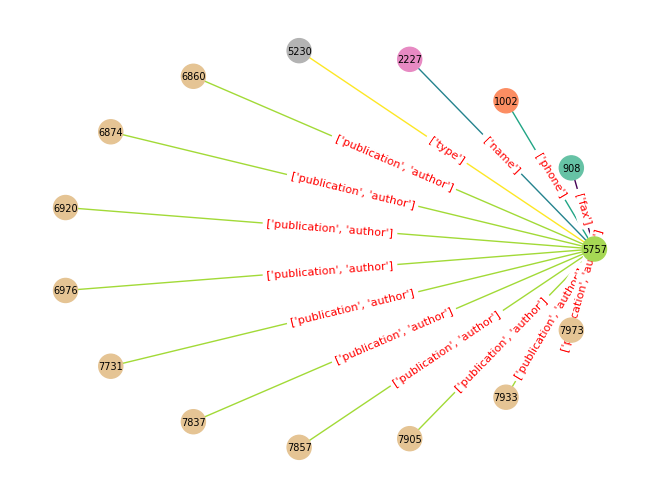

In [74]:

v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}_new')
res, weights = visualize(node_idx, 2, data, v, 0, name, result_weights=False, low_threshold=False)

In [192]:
import torch

def hor_ver_graph(triples, n, r):
    """
    input: triples, number of nodes, number of relations
    output: hor_graph, ver_graph : horizontally and vertically stacked adjacency matrix
    """

    hor_ind, hor_size = adj(triples, n, 2*r+1, vertical=False)
    ver_ind, ver_size = adj(triples, n, 2*r+1, vertical=True)

    rn, _ = hor_size  # horizontally stacked adjacency matrix size
    r = rn // n  # number of relations enriched divided by number of nodes

    vals = torch.ones(ver_ind.size(0), dtype=torch.float)  # number of enriched triples

    hor_graph = torch.sparse.FloatTensor(hor_ind.t(), vals, hor_size)  # size: n, r, emb
    ver_graph = torch.sparse.FloatTensor(ver_ind.t(), vals, ver_size)

    return hor_graph, ver_graph

def adj(triples, num_nodes, num_rels, cuda=False, vertical=True):
    """
     Computes a sparse adjacency matrix for the given graph (the adjacency matrices of all
     relations are stacked vertically).

     :param edges: List representing the triples
     :param i2r: list of relations
     :param i2n: list of nodes
     :return: sparse tensor
    """
    r, n = num_rels, num_nodes
    size = (r * n, n) if vertical else (n, r * n)

    from_indices = []
    upto_indices = []

    for s, p, o in triples:
        offset = p.item() * n
        s = offset + s.item() if vertical else s.item()
        o = offset + o.item() if not vertical else o.item()
        from_indices.append(s)
        upto_indices.append(o)

    indices = torch.tensor([from_indices, upto_indices], dtype=torch.long, device=d(cuda))

    return indices.t(), size



In [194]:
adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=True)
hor_ver_graph(data.triples, data.num_entities, data.num_relations)

(tensor([[352915,   5230],
         [352916,   5230],
         [352921,   5230],
         ...,
         [329873,   5230],
         [329889,   5230],
         [329890,   5230]]),
 (372825, 8285))

(tensor(indices=tensor([[  4945,   4946,   4951,  ...,   6758,   6774,   6775],
                        [353200, 353200, 353200,  ..., 328345, 328345, 328345]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(8285, 753935), nnz=26666, layout=torch.sparse_coo),
 tensor(indices=tensor([[352915, 352916, 352921,  ..., 329873, 329889, 329890],
                        [  5230,   5230,   5230,  ...,   5230,   5230,   5230]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(753935, 8285), nnz=26666, layout=torch.sparse_coo))

In [276]:

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
edge_h, edge_v = hor_graph.coalesce().indices(), ver_graph.coalesce().indices()
_,_,sub_edges_tensor_h  = find_n_hop_neighbors(edge_h,2, 5699)
_,_,sub_edges_tensor_v  = find_n_hop_neighbors(edge_v,2, 5699)


In [282]:
len(sub_edges_tensor_v)

0

In [247]:
sub_edges_tensor
indexes = sub_edges_tensor%data.num_entities
indexes
r = sub_edges_tensor//data.num_entities
r

tensor([[4945, 4946, 4951,  ..., 6758, 6774, 6775],
        [5230, 5230, 5230,  ..., 5230, 5230, 5230]])

tensor([[4945, 4946, 4951,  ..., 6758, 6774, 6775],
        [5230, 5230, 5230,  ..., 5230, 5230, 5230]])

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_39897/416362161.py:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  r = sub_edges_tensor//data.num_entities


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [239]:
_,p = torch.div(sub_edges_tensor, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
s,o = sub_edges_tensor%data.num_entities
result = torch.stack([s,p,o], dim=1)
result

tensor([[4945,    0, 5230],
        [4946,    0, 5230],
        [4951,    0, 5230],
        ...,
        [6758,    0, 5230],
        [6774,    0, 5230],
        [6775,    0, 5230]])

In [217]:
#try initialization where the first hop neighborhood gets initialized with 1s and the rest with different methods??
def construct_edge_mask(self, num_nodes,sparse_tensor,data, const_val=1.0, relation_id = 2):
    """
    Construct edge mask
    """
    init_strategy = self.init_strategy
    # if num_nodes > 1000:
    #     init(strategy="const", const_val=0.1)
    data = self.data
    num_entities = data.num_entities
    torch.manual_seed(42)
    mask = nn.Parameter(torch.FloatTensor(num_nodes))

    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val) 
    elif init_strategy == "zero_out":
        '''initialize the mask with the zero out strategy: we zero out edges belonging to specific relations'''
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
        output_indices, output_values, value_indices=select_relation(sparse_tensor,relation_id)
        _,_,value_indices1=select_relation(sparse_tensor,33)
        print(value_indices, value_indices1)
        value_indices = torch.cat((value_indices, value_indices1), 0)
        mask.data[[value_indices]] = 0
    

    elif init_strategy == "overall_frequency":
        '''Initialize the mask with the overall frequency of the relations'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        overall_rel_frequency = dict(Counter(data.triples[:,1].tolist()))#.most_common()

        overall_rel_frequency_  = {key: round(value/len(data.triples[:,1].tolist()),5) for key, value in overall_rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = overall_rel_frequency_[i]
    
    elif init_strategy == "relative_frequency":
        ''' Initialize the mask with the relative frequency of the relations-relative for the node to be explained'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        rel_frequency = dict(Counter(p))
        rel_frequency_  = {key: round(value/len(p),5) for key, value in rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = rel_frequency_[i]

    elif init_strategy == "inverse_relative_frequency":
        ''' Initialize the mask with the relative frequency of the relations-relative for the node to be explained'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        rel_frequency = dict(Counter(p))
        rel_frequency_  = {key: 1 - round(value/len(p),5) for key, value in rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = rel_frequency_[i]


    elif init_strategy == "domain_frequency":
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        dict_domain, dict_range = domain_range_freq(data, len(d_classes(data)))
        for i in p:

            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = dict_domain[i]

    elif init_strategy == "range_frequency":
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        dict_domain, dict_range = domain_range_freq(data, len(d_classes(data)))
        for i in p:
                _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
                mask.data[[value_indices]] = dict_range[i]
    elif init_strategy == "rdf":
        rdf = [i for i in range(data.num_relations) if 'rdf' in data.i2r[i]]
        for i in rdf:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = 0
    elif init_strategy == "owl":
        owl = [i for i in range(data.num_relations) if 'owl' in data.i2r[i]]
        for i in owl:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = 0
    print(f'mask initialized with {init_strategy} strategy: {mask}')   
    return mask

In [2]:
import numpy as np
np.exp(-10)

4.5399929762484854e-05

In [43]:

v  = torch.load('chk/aifb_chk/size_0.05_lr_0.1_epochs_30_threshold_0.7_init_normal/masked_adj/masked_ver5757')
h = torch.load('chk/aifb_chk/size_0.05_lr_0.1_epochs_30_threshold_0.7_init_normal/masked_adj/masked_hor5757')

In [38]:
v

tensor(indices=tensor([[ 23430,  23430,  23430,  ..., 329925, 329926, 329927],
                       [  5757,   5789,   5791,  ...,   5230,   5230,   5230]]),
       values=tensor([0.7401, 0.6510, 0.4919,  ..., 0.7693, 0.4461, 0.4092]),
       size=(753935, 8285), nnz=1132, layout=torch.sparse_coo)

In [44]:
nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > 0.7]
nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
nonzero_values = v.coalesce().values()[v.coalesce().values() > 0.7]
sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
sel_masked_ver

tensor(indices=tensor([[ 23430,  24407,  24503, 254307, 254341, 254436, 328834,
                        328881, 328898, 328908, 328933, 328935, 328946, 328996,
                        328999, 329014, 329155, 329156, 329157, 329163, 329166,
                        329167, 329272, 329273, 329274, 329299, 329348, 329351,
                        329356, 329357, 329379, 329402, 329405, 329438, 329447,
                        329468, 329487, 329497, 329519, 329525, 329543, 329544,
                        329555, 329558, 329587, 329623, 329625, 329659, 329698,
                        329705, 329708, 329718, 329769, 329782, 329798, 329845,
                        329898, 329925],
                       [  5757,   5791,   5791,   6860,   7837,   6976,   5230,
                          5230,   5230,   5230,   5230,   5230,   5230,   5230,
                          5230,   5230,   5230,   5230,   5230,   5230,   5230,
                          5230,   5230,   5230,   5230,   5230,   5230,   5230,

In [28]:
v = sub_sparse_tensor(v, 0.5, data, low_threshold=False)
h = sub_sparse_tensor(h, 0.5, data, low_threshold=False)

In [7]:
def sub(v):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() < 0.5]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() < 0.5]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver
    

In [13]:
def sub(v, threshold):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > threshold]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() > threshold]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver
sub(v, 0.5)

tensor(indices=tensor([[254307, 254436, 329166, 329272, 329357, 329379, 329405,
                        329468, 329487, 329497, 329555, 329625, 329718, 329769,
                        329798, 329925],
                       [  6860,   6976,   5230,   5230,   5230,   5230,   5230,
                          5230,   5230,   5230,   5230,   5230,   5230,   5230,
                          5230,   5230]]),
       values=tensor([0.5001, 0.5010, 0.5003, 0.5074, 0.5052, 0.5007, 0.5021,
                      0.5001, 0.5063, 0.5094, 0.5076, 0.5003, 0.5050, 0.5007,
                      0.5003, 0.5037]),
       size=(329926, 6977), nnz=16, layout=torch.sparse_coo)

In [31]:
def match_to_triples(v,h, data, sparse=True):
    if sparse:
        pv,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sv,ov = v.coalesce().indices()%data.num_entities
        result_v = torch.stack([sv,pv,ov], dim=1)
        ph,_ = torch.div(h.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sh,oh = h.coalesce().indices()%data.num_entities
        result_h = torch.stack([sh,ph,oh], dim=1)
        result = torch.cat((result_v, result_h), 0)


                    
    else:
        if len(h )!= 0:
            _,ph = torch.div(h, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sh,oh = h%data.num_entities
            result_h = torch.stack([sh,ph,oh], dim=1)
        if len(v)!=0:
            pv, _ = torch.div(v, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sv,ov = v%data.num_entities
            result_v = torch.stack([sv,pv,ov], dim=1)
        if len(h) != 0 and len(v) != 0:
            result = torch.cat((result_v, result_h), 0)
            print(pv,ph)
        if len(h) == 0:
            result = result_v
            print(pv)
        if len(v) == 0:
            result = result_h
            print(ph)
        

                    
    
    return result

m = match_to_triples(v,h, data, sparse=True)
Counter(m[:,1].tolist())




Counter({30: 2, 39: 14, 0: 16})

In [30]:
def match_to_triples(v, data, sparse=True):
    if sparse:
        # p,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        # s,o = v.coalesce().indices()%data.num_entities
        # result = torch.stack([s,p,o], dim=1)
        matching = []
        indexes = v.coalesce().indices()%data.num_entities
        for j in range(indexes.size()[1]):
            for triple in data.triples:
                if triple[0] == indexes[0][j] and triple[2] == indexes[1][j]:
                    matching.append(triple)
        result = torch.stack(matching)

                    
    else:
        matching = []
        for i,i2 in zip(v[:,0],v[:,1]):
            for j,j1,j2, index in zip(data[:,0],data[:,1],  data[:,2], range(len(data[:,0]))):
                if i == j and i2 == j2:
                    matching.append(data[index])
                    

        result = torch.stack(matching)
    
    return result
m = match_to_triples(h, data, sparse=True)
Counter(m[:,1].tolist())

Counter({39: 15, 2: 1})

In [22]:
def sub(v, threshold):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > threshold]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() > threshold]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver

def visualize(node_idx, n_hop, data, masked_ver,masked_hor, threshold,name, result_weights=True, low_threshold=False,experiment_name=None ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    mask = torch.vstack((masked_ver, masked_hor.t()))
    mask = sub(mask, threshold)
    print(mask)
    #select only nodes with a certain threshold
    sel_masked_ver = sub(masked_ver, threshold)
    sel_masked_hor = sub(masked_hor, threshold)
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    #mask = torch.vstack((sel_masked_ver, sel_masked_hor.t()))
    print('sel masked ver',mask)
    indices_nodes = mask.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = mask.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.numpy())
        print(triples_matched)
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)


    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    weights = [[item] if not isinstance(item, list) else item for item in weights]


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        # else:
        #     ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  


    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    color_list = list(encode_dict(dict_index).values())


    col_weights = [weights[i][0] for i in range(len(weights))]
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        rel = {k: [data.i2rel[i][0] for i in v] for k,v in rel.items()}
        col_weights = [sum(weights[i], 3) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
        print(res)
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        #plt.show()
        return res, weights
    


In [61]:
torch.vstack((v,h.t()))

tensor(indices=tensor([[ 23430,  23430,  23430,  ..., 776294, 776296, 776405],
                       [  5757,   5789,   5791,  ...,   7973,   7973,   7973]]),
       values=tensor([0.4981, 0.4939, 0.4888,  ..., 0.5037, 0.4862, 0.4832]),
       size=(1507870, 8285), nnz=2264, layout=torch.sparse_coo)

tensor(indices=tensor([[ 254307,  254436,  329166,  329272,  329357,  329379,
                         329405,  329468,  329487,  329497,  329555,  329625,
                         329718,  329769,  329798,  329925,  776294, 1082280,
                        1082280, 1082280, 1082280, 1082280, 1082280, 1082280,
                        1082280, 1082280, 1082280, 1082280, 1082280, 1082280,
                        1082280, 1082280],
                       [   6860,    6976,    5230,    5230,    5230,    5230,
                           5230,    5230,    5230,    5230,    5230,    5230,
                           5230,    5230,    5230,    5230,    7973,    5723,
                           5744,    6099,    6205,    6290,    6312,    6338,
                           6401,    6420,    6430,    6488,    6558,    6646,
                           6697,    6726]]),
       values=tensor([0.5001, 0.5010, 0.5003, 0.5074, 0.5052, 0.5007, 0.5021,
                      0.5001, 0.5063, 0.5094, 0.5076, 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


(Counter({'publication': 2, 'type': 14, 'abstract': 16}),
 [[30],
  [30],
  [39],
  [39],
  [39],
  [39],
  [39, 0],
  [39],
  [39],
  [39],
  [39],
  [39],
  [39],
  [39],
  [39],
  [39],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]])

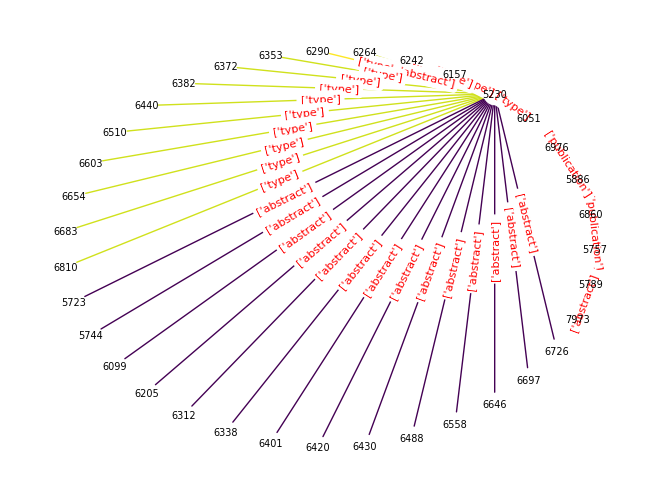

In [23]:
visualize(node_idx, 2, data, v,h, 0.5,name, result_weights=False, low_threshold=False,experiment_name=None )

In [62]:
data.i2r[39]

'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'